In [1]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torchvision.transforms as transforms
import time
import os

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

# 1. Load the Data

In [8]:
path = 'converted-data'

In [9]:
# Resize images to 288 x 288
transform = transforms.Compose([transforms.Resize((288, 288)),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                transforms.ToTensor()])

# Normalize the data later!!

# TRANSFORMING THE DATA
data = torchvision.datasets.ImageFolder(path, transform=transform)

In [10]:
train_data, valtest_data = random_split(data, (15587, 1948*2))
val_data, test_data = random_split(valtest_data, (1948, 1948))

In [11]:
# LOADING THE DATA
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)

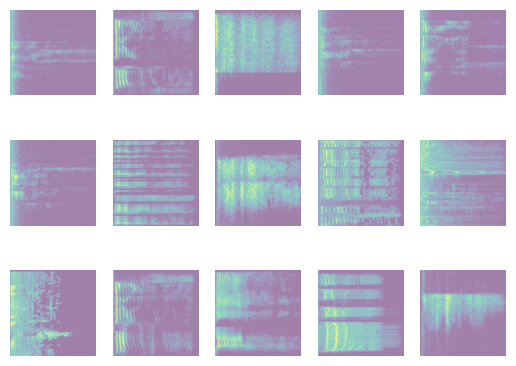

In [12]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [15]:
train_examples = len(train_loader)
validation_examples = len(val_loader)
test_examples = len(test_loader)

print("Number of training examples:", train_examples)
print("Number of validation examples:", validation_examples)
print("Number of testing examples:", test_examples)

Number of training examples: 15587
Number of validation examples: 1948
Number of testing examples: 1948


## 1.1. Class Distributions

In [21]:
data.class_to_idx

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

In [22]:
idx2class = {v: k for k, v in data.class_to_idx.items()}

In [23]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [ ]:
get_class_distribution(data)

In [25]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

In [ ]:
get_class_distribution_loaders(train_loader, data)

In [44]:
get_class_distribution_loaders(val_loader, data)

{'angry': 327,
 'disgust': 269,
 'fear': 292,
 'happy': 357,
 'neutral': 350,
 'sad': 353}

In [45]:
get_class_distribution_loaders(test_loader, data)

{'angry': 353,
 'disgust': 266,
 'fear': 271,
 'happy': 376,
 'neutral': 334,
 'sad': 348}

# 2. Define the Model

## 2.1. Function Definitions

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [4]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 5 x 5 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.softmax(self.fc1(x), dim=1)
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [30]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.name = "CNN3"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv11 = nn.Conv2d(5, 5, 1) # Pointwise convolution
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv22 = nn.Conv2d(10, 10, 1) # Pointwise convolution
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv33 = nn.Conv2d(15, 15, 1) # Pointwise convolution
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [5]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [34]:
def train(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=0, 
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=0, 
                                            shuffle=True)

    # training

    start_time = time.time()

    for epoch in range(num_epochs):
        n = 0
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            train_loss = criterion(out, labels) # compute the total loss => CHANGED labels to to labels.float()
            train_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        train_losses[epoch] = float(train_loss)/(n+1)             # compute *average* loss
        train_acc[epoch] = get_accuracy(model, train_loader, val_loader, train=True) # compute training accuracy 

        n = 0
        for imgs, labels in iter(val_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            val_loss = criterion(out, labels) # compute the total loss => CHANGED labels to to labels.float()
            val_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1        

        # save the current training information
        val_losses[epoch] = float(val_loss)/(n+1)             # compute *average* loss
        val_acc[epoch] = get_accuracy(model, train_loader, val_loader, train=False)  # compute validation accuracy
        
        print("Epoch:", epoch + 1, "| Training Accuracy:", train_acc[epoch], "| Validation Accuracy:", val_acc[epoch], "| Training Loss:", train_losses[epoch], "| Validation Loss:", val_losses[epoch])

        # checkpoints
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        model_path = "saved-models/" + model_path
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    # plotting
    plt.title("Loss Curves")
    plt.plot(range(1 ,num_epochs+1), train_losses, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print("Total Training Time:", round(end_time - start_time, 2), "seconds")

## 2.2. Model 1: Initial Model Training

Epoch: 1 | Training Accuracy: 0.3128247898890101 | Validation Accuracy: 0.31519507186858314
Epoch: 2 | Training Accuracy: 0.48559697183550393 | Validation Accuracy: 0.48408624229979463
Epoch: 3 | Training Accuracy: 0.5250529287226535 | Validation Accuracy: 0.5082135523613963
Epoch: 4 | Training Accuracy: 0.5727208571245268 | Validation Accuracy: 0.528747433264887
Epoch: 5 | Training Accuracy: 0.6160261756592031 | Validation Accuracy: 0.5446611909650924
Epoch: 6 | Training Accuracy: 0.6277025726567012 | Validation Accuracy: 0.5313141683778234
Epoch: 7 | Training Accuracy: 0.6785141464040546 | Validation Accuracy: 0.5595482546201233
Epoch: 8 | Training Accuracy: 0.7343298902931931 | Validation Accuracy: 0.601129363449692
Epoch: 9 | Training Accuracy: 0.7342657342657343 | Validation Accuracy: 0.5682751540041068
Epoch: 10 | Training Accuracy: 0.7850773080130878 | Validation Accuracy: 0.5657084188911704


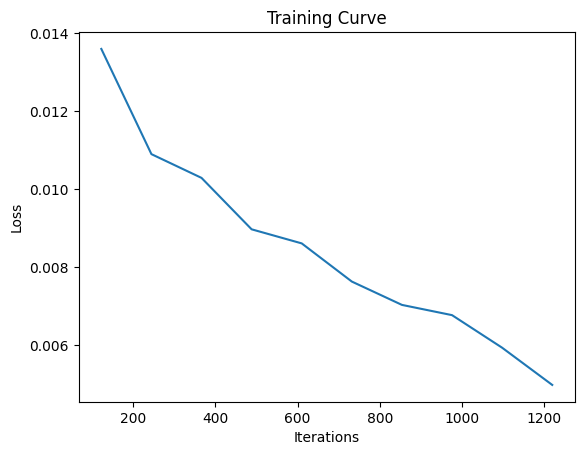

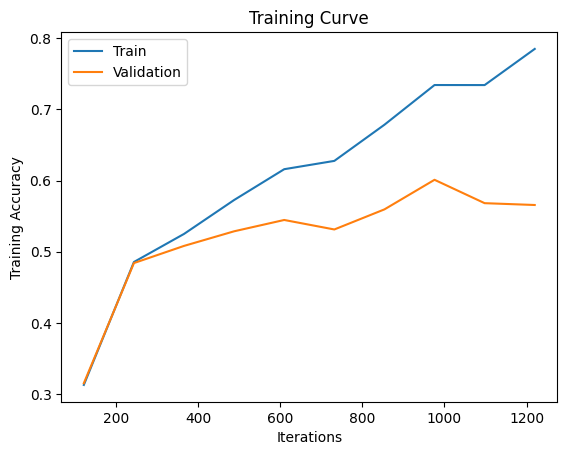

Final Training Accuracy: 0.7850773080130878
Final Validation Accuracy: 0.5657084188911704
Total Training Time: 4248.84 seconds


In [78]:
model_1 = CNN()
batch_size = 128
learning_rate = 0.01
num_epochs = 10
use_cuda = True
train(model_1, train_data, val_data, batch_size, learning_rate, num_epochs)

Epoch: 1 | Training Accuracy: 0.3628664913068583 | Validation Accuracy: 0.35164271047227924
Epoch: 2 | Training Accuracy: 0.4526207737216911 | Validation Accuracy: 0.4358316221765914
Epoch: 3 | Training Accuracy: 0.5353178931160583 | Validation Accuracy: 0.5046201232032854
Epoch: 4 | Training Accuracy: 0.5666260345159427 | Validation Accuracy: 0.5215605749486653
Epoch: 5 | Training Accuracy: 0.5834990697376018 | Validation Accuracy: 0.5097535934291582
Epoch: 6 | Training Accuracy: 0.643741579521396 | Validation Accuracy: 0.5687885010266941
Epoch: 7 | Training Accuracy: 0.6605504587155964 | Validation Accuracy: 0.5497946611909651
Epoch: 8 | Training Accuracy: 0.6601013665233849 | Validation Accuracy: 0.5431211498973306
Epoch: 9 | Training Accuracy: 0.7299031243985372 | Validation Accuracy: 0.5646817248459959
Epoch: 10 | Training Accuracy: 0.7564637197664721 | Validation Accuracy: 0.5569815195071869


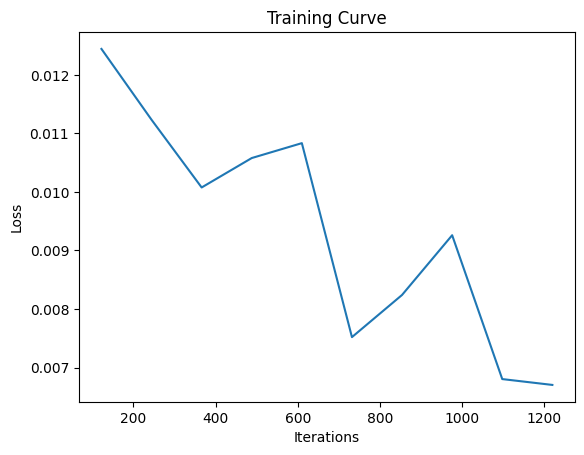

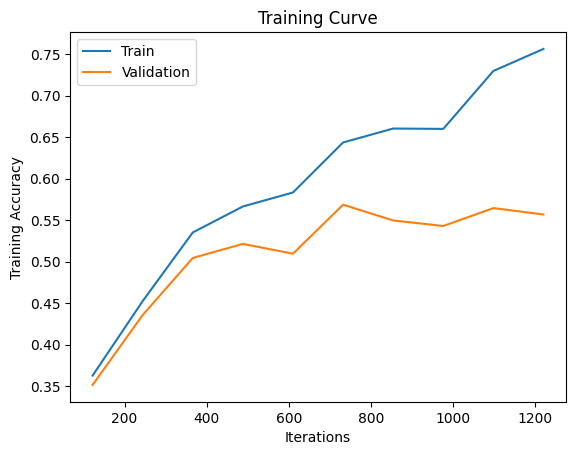

Final Training Accuracy: 0.7564637197664721
Final Validation Accuracy: 0.5569815195071869
Total Training Time: 5013.24 seconds


In [11]:
model_1 = CNN()
batch_size = 128
learning_rate = 0.01
num_epochs = 10
use_cuda = True
train(model_1, train_data, val_data, batch_size, learning_rate, num_epochs)

## 2.3. Accuracies for each class of emotion in model_1

In [13]:
best_model = CNN()
best_model_path = "saved-models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN", 128, 0.01, 9)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

In [14]:
def get_class_accuracy(best_model, path):
    transform = transforms.Compose([transforms.Resize((288, 288)),
                                    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                    transforms.ToTensor()])

    data = torchvision.datasets.ImageFolder(path, transform=transform)

    loader = torch.utils.data.DataLoader(data, batch_size=128, num_workers=0, shuffle=True)
    accuracy = get_accuracy(best_model, loader, loader)
    print("Accuracy:", accuracy)

In [16]:
path = 'converted-data-copy/angry1/'
get_class_accuracy(best_model, path)

Accuracy: 0.8095379146919431


In [23]:
path = 'converted-data-copy/disgust1/'
get_class_accuracy(best_model, path)

Accuracy: 0.08221119773210489


In [18]:
path = 'converted-data-copy/fear1/'
get_class_accuracy(best_model, path)

Accuracy: 0.038607376766632194


In [19]:
path = 'converted-data-copy/happy1/'
get_class_accuracy(best_model, path)

Accuracy: 0.050815217391304346


In [20]:
path = 'converted-data-copy/neutral1/'
get_class_accuracy(best_model, path)

Accuracy: 0.04007341694707862


In [21]:
path = 'converted-data-copy/sad1/'
get_class_accuracy(best_model, path)

Accuracy: 0.028238719068413392


## 2.4. Model 2: Try Softmax instead of ReLU

Epoch: 1 | Training Accuracy: 0.1761082953743504 | Validation Accuracy: 0.17967145790554415
Epoch: 2 | Training Accuracy: 0.1888753448386476 | Validation Accuracy: 0.18634496919917864
Epoch: 3 | Training Accuracy: 0.1888753448386476 | Validation Accuracy: 0.18634496919917864
Epoch: 4 | Training Accuracy: 0.1888753448386476 | Validation Accuracy: 0.18634496919917864
Epoch: 5 | Training Accuracy: 0.1888753448386476 | Validation Accuracy: 0.18634496919917864


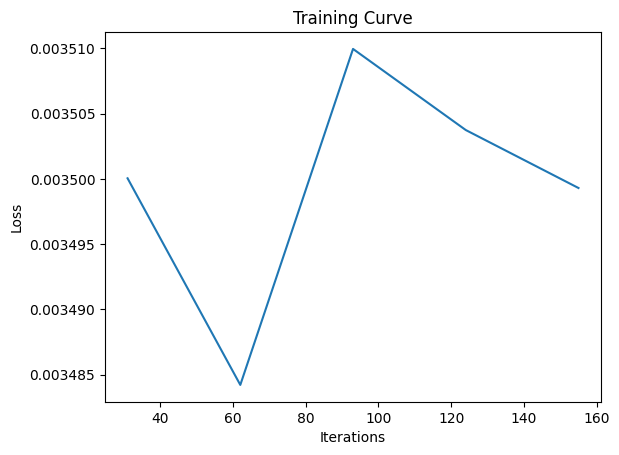

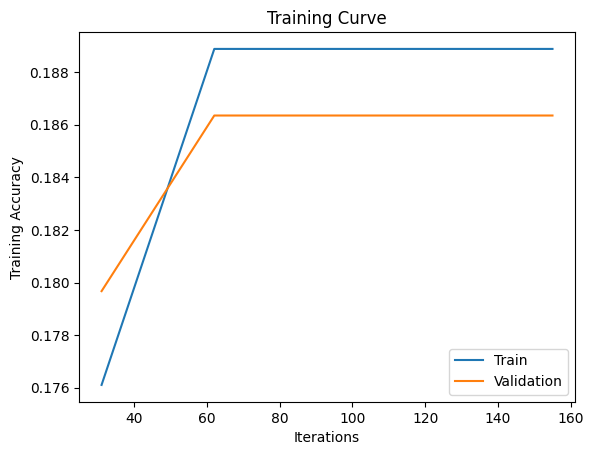

Final Training Accuracy: 0.1888753448386476
Final Validation Accuracy: 0.18634496919917864
Total Training Time: 2348.82 seconds


In [13]:
model_2 = CNN2()
batch_size = 512
learning_rate = 0.05
num_epochs = 5
use_cuda = True
train(model_2, train_data, val_data, batch_size, learning_rate, num_epochs)

## 2.5. Accuracies for each class (improved)

In [ ]:
def accuracy_per_class(model):
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        device = torch.device("cuda:0" is torch.cuda.is_available())
    else:
        device = torch.device("cpu")    
    #######################################

    model = model.to(device)
    model.eval()
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, num_workers=1, shuffle=True)

    errors = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # for a given true class, how many times did we guess wrong?
    total = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # total number of samples for each true class
    wrong_guesses = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # for each predicted class, how many were incorrect?
    guesses = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # total number of samples for each predicted class

    softmax = nn.Softmax(dim=1)
    for batch in val_loader:
        img, label = batch.values()
        if torch.cuda.is_available():
            img = img.to('cuda')
            label = label.to('cuda')
        output = softmax(model(img))
        pred = np.argmax(output.detach().cpu()).item()
        truth = np.argmax(label.cpu()).item()
        if pred != truth:
            errors[truth] += 1
            wrong_guesses[pred] += 1
        total[truth] += 1
        guesses[pred] += 1

    for i in range(15):
        if guesses[i] == 0:
            wrong_guesses[i] = guesses[i]
        else: 
            wrong_guesses[i] /= guesses[i]
        if total[i] == 0:
            errors[i] = 0
        else:
            errors[i] /= total[i]
    
    return errors, wrong_guesses, guesses, total

In [ ]:
def plot_accuracy_per_class(model):
    error_rate, wrong_guess_rate, guesses, total = accuracy_per_class(model)

    print(error_rate)
    print(wrong_guess_rate)
    print(guesses)
    print(total)

    x = np.array([0, 1, 2, 3, 4, 5])
    xtick = ["angry", "disgust", "fear", "happy", "neutral", "sad"]

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, error_rate.values())
    plt.title("Error rate per class")
    plt.xlabel("Class")
    plt.ylabel("Error rate")
    plt.show()

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, total.values())
    plt.title("Total samples per class")
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.show()

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, wrong_guess_rate.values())
    plt.title("Wrong guess rate per class")
    plt.xlabel("Class")
    plt.ylabel("Wrong guess rate")
    plt.show()

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, guesses.values())
    plt.title("Guesses per class")
    plt.xlabel("Class")
    plt.ylabel("Number of guesses")
    plt.show()

### 2.5.1. Model 1

In [ ]:
best_model = CNN()
best_model_path = "saved-models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN", 128, 0.01, 9)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

In [ ]:
plot_accuracy_per_class(best_model)

# 3. Hyperparameter Search

### Model 3

Epoch: 1 | Training Accuracy: 0.18913196894848272 | Validation Accuracy: 0.19301848049281314
Epoch: 2 | Training Accuracy: 0.3057034708410855 | Validation Accuracy: 0.29671457905544146
Epoch: 3 | Training Accuracy: 0.35003528581510235 | Validation Accuracy: 0.3521560574948665
Epoch: 4 | Training Accuracy: 0.38551356899980754 | Validation Accuracy: 0.37525667351129366
Epoch: 5 | Training Accuracy: 0.45736831975364084 | Validation Accuracy: 0.45790554414784396
Epoch: 6 | Training Accuracy: 0.45948546865978057 | Validation Accuracy: 0.4440451745379877
Epoch: 7 | Training Accuracy: 0.5009302623981523 | Validation Accuracy: 0.4851129363449692
Epoch: 8 | Training Accuracy: 0.5083723615833707 | Validation Accuracy: 0.4948665297741273
Epoch: 9 | Training Accuracy: 0.5177391415923526 | Validation Accuracy: 0.5025667351129364
Epoch: 10 | Training Accuracy: 0.5348688009238468 | Validation Accuracy: 0.5102669404517454
Epoch: 11 | Training Accuracy: 0.5743889138384551 | Validation Accuracy: 0.54004

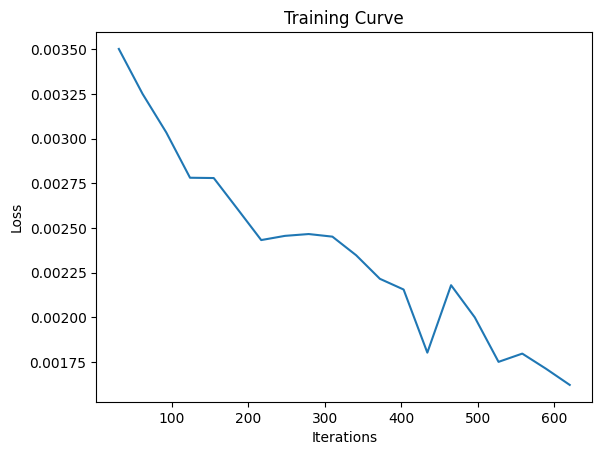

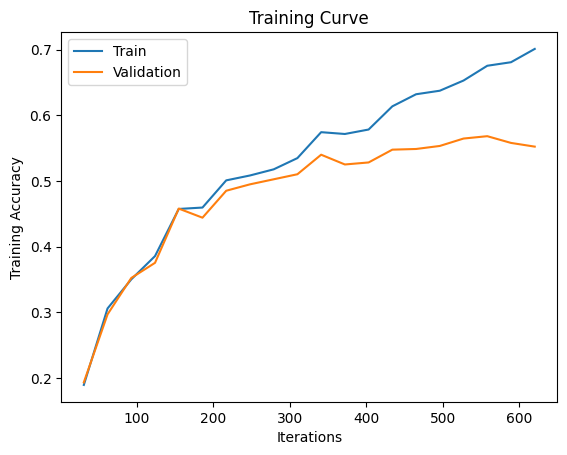

Final Training Accuracy: 0.7012895361519215
Final Validation Accuracy: 0.5523613963039015
Total Training Time: 8732.62 seconds


In [14]:
model_3 = CNN()
batch_size = 512
learning_rate = 0.05
num_epochs = 20
use_cuda = True
train(model_3, train_data, val_data, batch_size, learning_rate, num_epochs)

### Model 4

Epoch: 1 | Training Accuracy: 0.3449028036183999 | Validation Accuracy: 0.3526694045174538 | Training Loss: 0.006698548328131437 | Validation Loss: 0.006410835776478052
Epoch: 2 | Training Accuracy: 0.42920382369923654 | Validation Accuracy: 0.4317248459958932 | Training Loss: 0.005987474229186773 | Validation Loss: 0.005917269736528397
Epoch: 3 | Training Accuracy: 0.4725091422339129 | Validation Accuracy: 0.48357289527720737 | Training Loss: 0.004761242773383856 | Validation Loss: 0.004942835308611393
Epoch: 4 | Training Accuracy: 0.5236414961185604 | Validation Accuracy: 0.5436344969199178 | Training Loss: 0.0045568919740617275 | Validation Loss: 0.004603327251970768
Epoch: 5 | Training Accuracy: 0.561878488483993 | Validation Accuracy: 0.5775154004106776 | Training Loss: 0.004654250107705593 | Validation Loss: 0.004348255228251219
Epoch: 6 | Training Accuracy: 0.588695707961763 | Validation Accuracy: 0.6190965092402464 | Training Loss: 0.004045060835778713 | Validation Loss: 0.0040

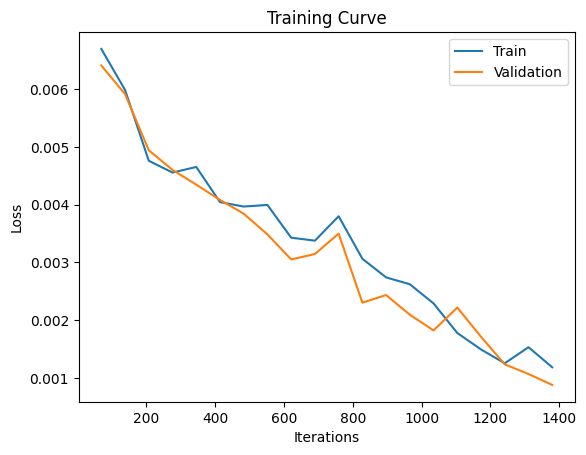

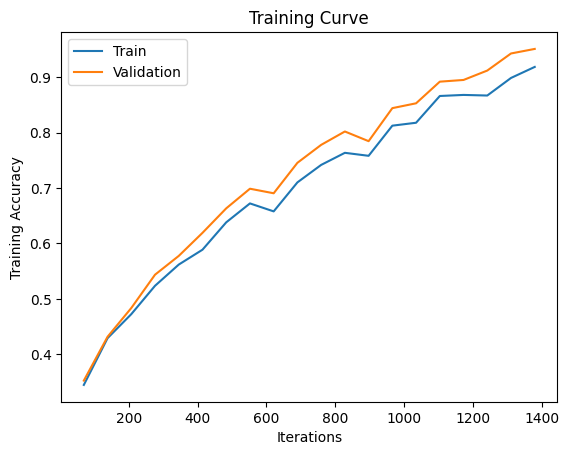

Final Training Accuracy: 0.9182652210175146
Final Validation Accuracy: 0.9507186858316222
Final Training Loss: 0.0011836913181468844
Final Validation Loss: 0.0008785076788626611
Total Training Time: 9192.44 seconds


In [18]:
model_4 = CNN()
batch_size = 256
learning_rate = 0.01
num_epochs = 20
use_cuda = True
train(model_4, train_data, val_data, batch_size, learning_rate, num_epochs)

## Model 4.1

In [33]:
model_4 = CNN()
batch_size = 256
learning_rate = 0.01
num_epochs = 5
use_cuda = True
train(model_4, train_data, val_data, batch_size, learning_rate, num_epochs)

KeyboardInterrupt: 

### Model 5

In [ ]:
model_5 = CNN3()
batch_size = 256
learning_rate = 0.05
num_epochs = 10
use_cuda = True
train(model_5, train_data, val_data, batch_size, learning_rate, num_epochs)

# 4. Test Data